In [98]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml import Pipeline
from preprocessing.preprocessor import split_data, class_imbalance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
spark = SparkSession.builder.appName("Pipeline").config('spark.executor.cores', 8).getOrCreate()

In [100]:
# spark.stop()

In [101]:
# Load data
data = spark.read.csv("dataset/creditcard.csv", header=True, inferSchema=True).cache()
data.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

24/12/06 22:24:50 WARN CacheManager: Asked to cache already cached data.


In [102]:
# Preprocessing

# Create an assembler as the first stage of the pipeline
assembler = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")

# Create a scaler as the second stage of the pipeline
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

## Model Saving and Loading
Since we have already trained a model and saved it, we can load it instead of training a new model. However, we will check if the model exists in the models directory. If it does not exist, we will train a new model and save it.

In [103]:
# Check if we already have a model saved in models directory
# If not, create a new model
# If we have a model saved, load it
rf_model = None 
try:
    rf_model = RandomForestClassificationModel.load("models/credit_card_fraud_detection_model")
except Exception as e:
    print("Model not found. Training a new model.")
    rf_model = RandomForestClassifier(featuresCol="scaled_features", labelCol="Class") 

In [104]:
# Create a pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf_model])

# Pipeline restriction
Now that we are inside the pipeline, the assembling and scaling will happen to the data we feed in

In [105]:
# Split training and testing data
df_balanced = class_imbalance(data)
train_split, test_split = split_data(df_balanced, 42)
train_unsplit, test_unsplit = split_data(data, 42)

Fraudulent transactions: 492
Non-fraudulent transactions: 284315 before balancing


In [106]:
print("Split data")
print(f"Train data count: {train_split.count()}")
print(f"Test data count: {test_split.count()}")

print("\nUnsplit data")
print(f"Train data count: {train_unsplit.count()}")
print(f"Test data count: {test_unsplit.count()}")

Split data
Train data count: 785
Test data count: 188

Unsplit data
Train data count: 228045
Test data count: 56762


In [107]:
# Fit the pipeline with unbalanced data
import time
start = time.perf_counter()
pipeline_model = pipeline.fit(train_split)
end = time.perf_counter()
print(f"Time taken for training: {end-start:.6f}s")

Time taken for training: 0.305753s


In [108]:
# Make predictions
start = time.perf_counter()
predictions = pipeline_model.transform(test_split)
end = time.perf_counter()
print(f"Time taken for prediction: {end-start:.6f}s")

Time taken for prediction: 0.055841s


In [109]:
predictions.show(5)

+------+------------------+----------------+------------------+----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  Time|                V1|              V2|                V3|              V4|                V5|                 V6|                V7|                V8|                V9|              V10|             V11|              V12|               V13|              V14|               V15|               V16|              V17|              V18|               V19

In [110]:
# Save the pipeline
# pipeline_model.write().overwrite().save("pipeline/credit_card_fraud_detection_pipeline")

In [111]:
predictions.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [112]:
# Evaluate the model

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Class")
print(f"Area under ROC: {evaluator.evaluate(predictions)}")

Area under ROC: 0.9086149994309775


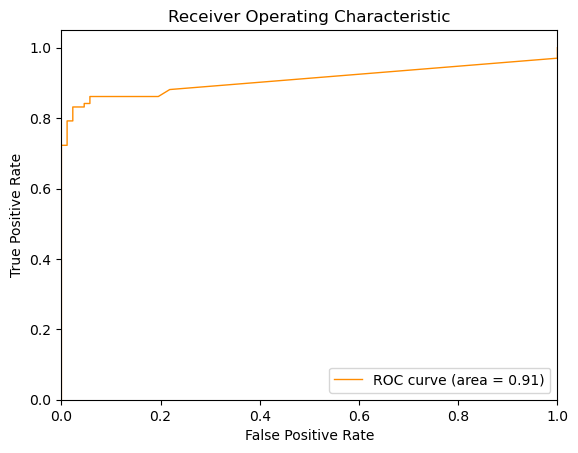

In [113]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert the predictions to a Pandas DataFrame
predictions_df = predictions.select('Class', 'probability').toPandas()

# Get the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(predictions_df['Class'], predictions_df['probability'].apply(lambda x: x[1]))

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()